# Fatty Liver Disease (FLD) Study

- alcoholic vs non-alcoholic FLD, short: AFLD vs NAFLD


**Outline**

1. Study on liver disease types:
    1. Fibrosis
    1. Steatosis
    2. Inflammation
    
2. Two data sets with 
    1. clinical markers
    2. proteome information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.linear_model as skllm
import sklearn.ensemble as skle

import sklearn.metrics as sklm
import sklearn.model_selection as sklms
from sklearn.model_selection import cross_val_predict

import xgboost
import ipywidgets as widgets

In [2]:
import src.utils as utils

In [3]:
import os
CPUS = os.cpu_count()
RANDOMSTATE = 29
DATAFOLDER = 'processed/ML'

# Explore datasets

Diagnostic comparators (existing best-in-class) biomarkers
- Fibrosis markers: transient elastography, 2-dimensional shear wave elastography, ELF test, FibroTest, FIB4 score, APRI score, Forns score, ProC3
- Inflammation markers: M30=caspase-cleaved cytokeratin-18 fragments, M65=total CK18, AST:ALT ratio, ProC3
- Steatosis: Controlled attenuation parameter

In [4]:
pd.set_option('max_columns', 9)

files = [file for file in os.listdir(DATAFOLDER) if '.csv' in file]
w_data = widgets.Dropdown(options=files, index=5)

def show_data(file):
    filename = os.path.join(DATAFOLDER, file)
    global data # only here to show-case data for report
    try:
        data = pd.read_csv(filename, index_col='Sample ID')
    except:
        data = pd.read_csv(filename)
    display(data.head())
out = widgets.interactive_output(show_data, controls={'file':w_data})

widgets.VBox([w_data, out])

In [5]:
# # Possible Alternative for DropDown 
# from src.widgets import multi_checkbox_widget

# descriptions=data.columns
# w_cols = multi_checkbox_widget(descriptions)
# w_cols

In [6]:
w_cols = widgets.SelectMultiple(options=list(data.columns))

def show_selected_proteins(columns):
    if len(columns)> 0:
        display(data[list(w_cols.value)])
        print(data[list(w_cols.value)].describe())
    else:
        print('Select proteins')

out_sel = widgets.interactive_output(show_selected_proteins, {'columns': w_cols})
widgets.VBox([w_cols, out_sel])

## Proteomics data

### Load Complete proteomics data

Full preprocessing pipeline

In [7]:
FOLDER_DATA_RAW = 'data/raw'
annotation_file = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'Experiment annotation file.csv'), index_col = [0])
annotation_file_plasma = annotation_file[annotation_file['Sample type'] == 'Plasma']
annotation_file_plasma.index = pd.Index(annotation_file_plasma.index, dtype=int)
display(annotation_file_plasma.head())
annotation_file_plasma.describe()

,File name,Sample ID,Groups,Species,Group2,Sample type
0,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A1,QC,Human,QC,Plasma
1,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A2,HP,Human,HP,Plasma
2,[3] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A3,HP,Human,HP,Plasma
3,[4] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A4,ALD,Human,ALD,Plasma
4,[5] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A5,ALD,Human,ALD,Plasma


,File name,Sample ID,Groups,Species,Group2,Sample type
count,603,603,603,603,603,603
unique,603,603,4,1,3,1
top,[150] 20190517_QE10_Evosep1_P0000005_LiNi_SA_P...,Plate2_A6,ALD,Human,ALD,Plasma
freq,1,1,355,603,459,603


In [8]:
annotation_file_plasma["Sample ID"]

0       Plate1_A1
1       Plate1_A2
2       Plate1_A3
3       Plate1_A4
4       Plate1_A5
          ...    
598    Plate7_C10
599    Plate7_C11
600    Plate7_C12
601     Plate7_D1
602     Plate7_D2
Name: Sample ID, Length: 603, dtype: object

In [9]:
report_plasma = pd.read_csv(os.path.join(FOLDER_DATA_RAW, '20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv'), na_values='Filtered' )
report_plasma.rename({'PG.Genes': 'Gene names', 'PG.ProteinAccessions': 'Protein ID'}, inplace= True, axis=1)
report_plasma.head()
columns_ = ['Protein ID', 'Gene names']
ids_ = report_plasma[columns_].apply(lambda series_: series_.str.split(';'))

In [10]:
ids_ # ToDo:  create mapping object (see if proteins are unique -> get function from other project)

,Protein ID,Gene names
0,[A0A024R6I7],[SERPINA1]
1,[A0A075B6I0],[IGLV8-61]
2,[A0A075B6J9],[IGLV2-18]
3,"[A0A075B6R9, A0A0C4DH68]","[IGKV2D-24, IGKV2-24]"
4,"[A0A075B6S2, A2NJV5]","[IGKV2D-29, IGKV2-29]"
...,...,...
519,[Q9Y5Y7],[LYVE1]
520,[Q9Y646],[CPQ]
521,[Q9Y6R7],[FCGBP]
522,[Q9Y6Z7],[COLEC10]


In [11]:
def length_(x):
    try:
        return len(x)
    except:
        return 0
    
count_groups_proteins = ids_.apply(lambda series_: series_.apply(length_))
def compare_count(df, column_1, column_2):
    """Takes pandas.DataFrame and two of it's columns. Returns counts of 
    two columns for values of the two columns."""
    return df[column_1].value_counts().sort_index().to_frame().merge(
        df[column_2].value_counts().sort_index(),
        left_index=True, right_index=True, how='outer')
       
# count_groups_proteins = count_groups_proteins[columns_[0]].value_counts().sort_index().to_frame().merge(
#         count_groups_proteins[columns_[1]].value_counts().sort_index(),
#         left_index=True, right_index=True, how='outer')
compare_count(count_groups_proteins, *columns_)

,Protein ID,Gene names
0,NaN,2.0
1,318.0,499.0
2,121.0,11.0
3,44.0,3.0
4,20.0,2.0
5,7.0,3.0
6,6.0,1.0
7,1.0,NaN
8,1.0,NaN
10,1.0,NaN


In [12]:
NP_LOG_FCT = np.log2

def log2(row: pd.Series):
    """Apply log Transformation to values."""
    return NP_LOG_FCT(row.where(row != 0.0))

RANDOMSEED = 123

IMPUTATION_MEAN_SHIFT    = 1.8
IMPUTATION_STD_SHRINKAGE = 0.3

def imputation_normal_distribution(log_intensities: pd.Series, mean_shift=IMPUTATION_MEAN_SHIFT, std_shrinkage=IMPUTATION_STD_SHRINKAGE):
    """Impute missing log-transformed intensity values of DDA run.

    Parameters
    ----------
    log_intensities: pd.Series
        Series of normally distributed values. Here usually log-transformed
        protein intensities.
    mean_shift: integer, float
        Shift the mean of the log_intensities by factors of their standard
        deviation to the negative.
    std_shrinkage: float
        Value greater than zero by which to shrink (or inflate) the 
        standard deviation of the log_intensities.
    """
    np.random.seed(RANDOMSEED)
    if not isinstance(log_intensities, pd.Series):
        try:
            log_intensities.Series(log_intensities)
            logger.warning("Series created of Iterable.")
        except:
            raise ValueError(
                "Plese provided data which is a pandas.Series or an Iterable")
    if mean_shift < 0:
        raise ValueError(
            "Please specify a positive float as the std.-dev. is non-negative.")
    if std_shrinkage <= 0:
        raise ValueError(
            "Please specify a positive float as shrinkage factor for std.-dev.")
    if std_shrinkage >= 1:
        logger.warning("Standard Deviation will increase for imputed values.")

    mean = log_intensities.mean()
    std = log_intensities.std()

    mean_shifted = mean - (std * mean_shift)
    std_shrinked = std * std_shrinkage

    return log_intensities.where(log_intensities.notna(),
                                 np.random.normal(mean_shifted, std_shrinked))

In [13]:
# Report_plasma = pd.read_csv('raw/proteomics/plasma/20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv')
experimental_columns = annotation_file_plasma['Sample ID']
report_plasma[columns_] = report_plasma[columns_].apply(lambda series_: series_.str.split(';').str[0])

In [14]:
report_plasma.describe()

,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A1.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A2.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[3] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A3.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[4] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A4.htrms.PG.NrOfStrippedSequencesUsedForQuantification,...,[600] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C11.htrms.PG.Quantity,[601] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C12.htrms.PG.Quantity,[602] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D1.htrms.PG.Quantity,[603] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D2.htrms.PG.Quantity
count,361.000000,327.000000,317.000000,340.000000,...,3.640000e+02,3.200000e+02,3.130000e+02,3.220000e+02
mean,2.124654,2.171254,2.192429,2.191176,...,3.939520e+06,4.541551e+06,4.727407e+06,4.267386e+06
std,0.933022,0.927444,0.912747,0.903245,...,4.108969e+07,4.513567e+07,4.711617e+07,4.104998e+07
min,1.000000,1.000000,1.000000,1.000000,...,1.908130e+02,5.826772e+02,7.995712e+02,2.039593e+02
25%,1.000000,1.000000,1.000000,1.000000,...,8.566062e+03,1.047221e+04,1.268499e+04,1.084710e+04
50%,3.000000,3.000000,3.000000,3.000000,...,4.154654e+04,6.404788e+04,6.787159e+04,6.053365e+04
75%,3.000000,3.000000,3.000000,3.000000,...,4.774295e+05,6.070775e+05,7.744870e+05,6.438288e+05
max,3.000000,3.000000,3.000000,3.000000,...,7.727070e+08,7.973126e+08,8.239611e+08,7.269720e+08


In [15]:
map_filenames_ids = dict(zip(annotation_file['File name'], annotation_file['Sample ID']))

Remove some measurements which are not intensities, but ... ?

In [16]:
data_plasma_raw = report_plasma.copy()
data_plasma_raw.drop(data_plasma_raw.filter(regex='StrippedSequences').columns, axis=1, inplace = True)

- rename column names to sample ID from annotation file
- set index to proteins

In [17]:
data_plasma_raw = data_plasma_raw.rename(mapper = map_filenames_ids, axis=1)
IDmapping_UniprotID_to_Genename = dict(zip(data_plasma_raw['Protein ID'], data_plasma_raw['Gene names']))
data_plasma_raw = data_plasma_raw.set_index('Protein ID').drop('Gene names', axis = 1)
data_plasma_raw.shape

(524, 603)

In [18]:
mask = data_plasma_raw.notna().sum(axis=1) > 603 * 0.6
mask.sum()

304

Filter at protein level for 60% data completeness across all runs

In [19]:
DATA_COMPLETENESS = 0.6
data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * DATA_COMPLETENESS)
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


Filter at sample level for a total number of quantified protein groups above 200 (of 290).

In [20]:
MIN_N_PROTEIN_GROUPS = 200
print(f"Min No. of Protein-Groups in single sample: {MIN_N_PROTEIN_GROUPS}, i.e. a fraction of {MIN_N_PROTEIN_GROUPS/len(data_plasma_filtered)}")

Min No. of Protein-Groups in single sample: 200, i.e. a fraction of 0.6578947368421053


In [21]:
data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


In [22]:
assert (data_plasma_filtered.dtypes != float).sum() == 0

In [23]:
# data_plasma_filtered = convert_to_numeric(data_plasma_filtered)
# data_plasma_filtered_log = np.log2(data_plasma_filtered)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
data_plasma_filtered_log

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,19.241954,21.152989,14.658642,12.382140,...,12.006154,11.550063,NaN,20.923524
A0A075B6I0,19.263925,19.688738,17.856901,18.475045,...,18.849272,18.415463,18.226387,18.530668
A0A075B6J9,17.359595,17.312205,17.501147,16.482787,...,15.134411,17.057015,17.021873,19.259006
A0A075B6R9,18.526168,18.980010,18.552370,18.053848,...,16.578231,18.503624,17.433012,17.229518
A0A075B6S2,21.897501,21.791846,21.193585,21.543841,...,21.897031,22.249955,22.366180,22.563550
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,12.248479,12.370819,12.929078,11.646316,...,12.772336,11.199029,12.453085,12.019185
Q9Y5Y7,14.282206,14.722489,14.725822,13.838443,...,13.712093,13.139398,13.203252,13.381890
Q9Y6R7,13.487235,14.068817,14.930436,14.300234,...,12.995997,12.991006,NaN,12.792394


##### Imputation

- imputation is done before coefficient of variation (CV)
- is this sensible?

In [24]:
data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)

In [25]:
assert data_plasma_filtered_log_imputed.loc['Q9Y6Z7', 'Plate1_A2'] - 9.770809 < 0.0001, 'Imputed value changed in comparison to previous run'

In [26]:
# ToDo: Look at distribution of imputed values vs non-imputed values by protein.

In [27]:
from pathlib import Path
file = Path('data/processed/plasma_processed.csv')
file.parent.mkdir(parents=True, exist_ok=True)

In [28]:
import logging
try:
    data_plasma_filtered_log_imputed.to_csv(file.absolute())
except PermissionError as e:
    logging.warning(f"No write permission to directory: {e}")

ToDo: Standardize before imputing ?

In [29]:
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


In [30]:
qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
coef_of_variation = lambda x: np.std(x) / np.mean(x)
proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

In [31]:
CV_COEFFICIENT = 0.3
cv_selected = proteins_cv < CV_COEFFICIENT
print(f"Selected proteins # {cv_selected.sum()} of a total of # {len(cv_selected)}!")

Selected proteins # 219 of a total of # 304!


In [32]:
df_qc = df_qc.assign(cv = proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment 
df_30 = df[qc_30]
data_proteomics = df_30

In [33]:
data_proteomics

Protein ID,A0A024R6I7,A0A075B6I0,A0A075B6J9,A0A075B6R9,...,Q9Y5C1,Q9Y5Y7,Q9Y6Z7,V9GYM3
Sample ID,,,,,,,,,
Plate1_A1,19.241954,19.263925,17.359595,18.526168,...,12.248479,14.282206,13.201056,24.410428
Plate1_A2,21.152989,19.688738,17.312205,18.980010,...,12.370819,14.722489,9.503856,24.562142
Plate1_A3,14.658642,17.856901,17.501147,18.552370,...,12.929078,14.725822,13.830207,24.776309
Plate1_A4,12.382140,18.475045,16.482787,18.053848,...,11.646316,13.838443,9.544955,24.402429
Plate1_A5,11.449945,18.653026,15.673456,17.827835,...,12.144853,14.278546,9.453771,24.842651
...,...,...,...,...,...,...,...,...,...
Plate7_C10,13.992607,17.711436,17.170434,17.593782,...,12.622469,13.450106,14.258025,24.261786
Plate7_C11,12.006154,18.849272,15.134411,16.578231,...,12.772336,13.712093,12.411197,23.681672
Plate7_C12,11.550063,18.415463,17.057015,18.503624,...,11.199029,13.139398,9.166826,24.232875


In [34]:
intensities_below_8 = data_proteomics[data_proteomics < 8].dropna(how='all').dropna(how='all', axis=1)
intensities_below_8

Protein ID,E9PEP6,P20742,P23470,P29508,P32119,P34096,Q86UD1
Sample ID,,,,,,,
Plate2_G11,7.943981,NaN,NaN,NaN,NaN,NaN,NaN
Plate3_E12,NaN,NaN,NaN,NaN,6.6718,NaN,NaN
Plate5_C4,NaN,NaN,NaN,NaN,NaN,0.0,NaN
Plate5_C9,NaN,NaN,NaN,NaN,NaN,NaN,7.997238
Plate5_H7,NaN,NaN,0.0,NaN,NaN,NaN,NaN
Plate6_C4,NaN,NaN,NaN,6.994776,NaN,NaN,NaN
Plate7_A9,NaN,7.516699,NaN,NaN,NaN,NaN,NaN


In [35]:
data_proteomics.loc[intensities_below_8.index, intensities_below_8.columns]

Protein ID,E9PEP6,P20742,P23470,P29508,P32119,P34096,Q86UD1
Sample ID,,,,,,,
Plate2_G11,7.943981,9.218392,12.627170,9.218392,12.689431,12.141700,14.219719
Plate3_E12,8.930690,18.398998,12.498869,8.930690,6.671800,11.506953,13.143613
Plate5_C4,8.748182,18.163920,12.993120,21.373968,13.405002,0.000000,12.974315
Plate5_C9,9.181562,15.631481,12.443023,21.339160,14.487712,11.500707,7.997238
Plate5_H7,8.675619,14.654771,0.000000,21.481735,13.630898,11.832212,13.037990
Plate6_C4,13.914996,12.411481,13.779482,6.994776,12.838674,12.912724,9.326952
Plate7_A9,12.679690,7.516699,13.676987,21.267399,15.309246,9.170928,9.170928


Data proteomics is the summary of the following processing steps:

1. protein is selected if shared betw. 60% of samples
2. sample is selected if it has at least 200 proteins
3. log-transform
4. imputation (imputation done per protein between runs)
5. selection using CV < 0.3

> Maybe create an automated report of the cutoffs.

In [36]:
summary_protein_preprocessing = [("Proportion protein has to be shared between samples" , DATA_COMPLETENESS),
                                 ("Minimum number of protein in single sample", MIN_N_PROTEIN_GROUPS),
                                 ("Maximum coefficient of variation (CV) for protein intensities", CV_COEFFICIENT),
                                 ("Logarithm employed for transformation", NP_LOG_FCT),
                                 ("Imputation: Mean-Shift", IMPUTATION_MEAN_SHIFT), 
                                 ("Imputation: Std-Dev. shrinkage", IMPUTATION_STD_SHRINKAGE)
                                ]

### Load Protein GeneID Mapping

- UniProtID to Gene name mapping
- the assigned protein groups are mapped to mainly one, sometimes two genes -> Global Identifiers?!


In [37]:
key_ProteinID = pd.read_csv(os.path.join(DATAFOLDER, 'ID_matching_key.csv'), 
                            index_col="Protein ID").drop("Unnamed: 0", axis=1)
key_ProteinID.head()

,Gene names
Protein ID,
A0A024R6I7,SERPINA1
A0A075B6I0,IGLV8-61
A0A075B6J9,IGLV2-18
A0A075B6R9,IGKV2D-24
A0A075B6S2,IGKV2D-29


In [38]:
key_ProteinID.loc['P35858']

Gene names    IGFALS
Name: P35858, dtype: object

## Clinical data
### Load Complete clinical data

In [39]:
PROTEOM  = 'data_ml_proteomics.csv'
CLINICAL = 'df_cli_164.csv'
COL_ID = 'Sample ID'
f_data_clinic = os.path.join(DATAFOLDER, CLINICAL)
data_cli = pd.read_csv(f_data_clinic, index_col=COL_ID)
data_cli = data_cli[data_cli['kleiner']!=0.5]
data_cli.head()

,age,kleiner,cpa,nas,...,group,group2,type,fibrosis_class
Sample ID,,,,,,,,,
Plate6_G11,64,3.0,9.216155,0.0,...,ALD,ALD,Compensated advanced fibrosis,F3-4
Plate1_F7,74,2.0,4.874057,3.0,...,ALD,ALD,Steatohepatitis,F2
Plate6_D2,71,1.0,3.199472,3.0,...,ALD,ALD,Steatohepatitis,F0-1
Plate6_C5,53,2.0,4.762666,5.0,...,ALD,ALD,Steatohepatitis,F2
Plate4_F8,63,4.0,13.702832,4.0,...,ALD,ALD,Compensated advanced fibrosis,F3-4


In [40]:
w_cols_cli = widgets.SelectMultiple(options=list(data_cli.columns))

def show_selected_markers(columns):
    if len(columns)> 0:
        display(data_cli[list(w_cols_cli.value)])
        display(data_cli[list(w_cols_cli.value)].describe())
    else:
        print('Select clinical markers')

out_cli = widgets.interactive_output(show_selected_markers, {'columns': w_cols_cli})
widgets.VBox([w_cols_cli, out_cli])

### Selected Clinical markers

Diagnostic comparators (existing best-in-class) biomarkers
- state-of-the-art (**SOTA**) Fibrosis markers: 
    - `te`: transient elastography (sona liver scan)
    - `swe`: 2-dimensional shear wave elastography
    - `elf`: ELF test
    - `ft`: FibroTest
    - `fib4`: FIB4 score
    - `apri`: APRI score
    - `forns`: Forns score
    - `p3np`: ProC3
- Inflammation markers:
    - M30=caspase-cleaved cytokeratin-18 fragments
    - M65=total CK18
    - AST:ALT ratio
    - ProC3
- Steatosis: Controlled attenuation parameter

In [41]:
#SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
SOTA_fibrosis = ['elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].count()

,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,
0.0,35,33,36,36,36,35
1.0,120,93,120,121,123,113
2.0,104,76,104,104,103,95
3.0,27,17,26,26,27,22
4.0,63,49,66,66,67,54


In [42]:
pd.set_option('max_columns', 20)
FEATURES_ML = ['nas_steatosis_ordinal', 'nas_inflam', 'kleiner', 
          'fib4', 'elf', 'ft', 'te', 'swe', 'aar','ast',
          'apri','forns','m30', 'm65', 'meld', 'p3np', 'timp1', 'cap' ]
data_cli[FEATURES_ML].head()

,nas_steatosis_ordinal,nas_inflam,kleiner,fib4,elf,ft,te,swe,aar,ast,apri,forns,m30,m65,meld,p3np,timp1,cap
Sample ID,,,,,,,,,,,,,,,,,,
Plate6_G11,0.0,0.0,3.0,1.380000,8.7,0.29,9.3,NaN,1.50,27.0,0.20,4.75,106.672000,293.25601,7.0,4.8,230.6,NaN
Plate1_F7,1.0,2.0,2.0,8.220000,9.8,0.77,NaN,NaN,2.48,57.0,1.18,8.82,161.834000,438.91800,12.0,7.8,318.7,NaN
Plate6_D2,1.0,2.0,1.0,2.220000,9.6,0.34,8.7,13.1,1.73,26.0,0.27,6.65,84.621803,502.39999,8.0,8.8,276.4,NaN
Plate6_C5,2.0,3.0,2.0,32.700001,11.3,0.83,19.1,NaN,3.71,267.0,11.63,11.88,668.940980,1432.85000,10.0,20.9,549.2,NaN
Plate4_F8,0.0,4.0,4.0,1.660000,11.3,0.52,75.0,28.0,1.48,37.0,0.29,5.70,491.866000,857.37500,7.0,22.0,545.6,NaN


In [43]:
data_cli.groupby('group2')[FEATURES_ML].count()

,nas_steatosis_ordinal,nas_inflam,kleiner,fib4,elf,ft,te,swe,aar,ast,apri,forns,m30,m65,meld,p3np,timp1,cap
group2,,,,,,,,,,,,,,,,,,
ALD,352,352,360,353,350,268,342,332,353,354,354,357,268,266,360,320,320,206
HP,0,0,0,0,0,0,136,136,0,119,0,0,0,0,136,0,0,133


In [44]:
SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].median()

,te,swe,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,,,
0.0,4.40,5.750000,8.30,0.10,1.070,0.270,3.775,7.2
1.0,6.00,6.700000,8.80,0.12,1.195,0.270,4.470,7.2
2.0,9.00,9.300000,9.55,0.34,1.655,0.440,5.820,9.9
3.0,21.60,16.900000,10.60,0.63,2.080,0.485,7.020,13.3
4.0,40.75,28.400001,11.80,0.78,4.000,0.860,8.150,22.4


### Selected Demographics

In [45]:
demographics = data_cli[['age', 'bmi', 'gender_num']] # 1 is male
demographics.describe()

,age,bmi,gender_num
count,497.000000,487.000000,497.000000
mean,54.953722,27.194539,0.726358
std,10.433153,5.180561,0.446277
min,19.000000,13.737373,0.000000
25%,48.000000,23.849999,0.000000
50%,56.000000,26.799999,1.000000
75%,62.000000,30.286856,1.000000
max,75.000000,52.099998,1.000000


### Targets

In [46]:
fibrosis_score = data_cli.kleiner
inflamation_score = data_cli.nas_inflam
steatosis_score = data_cli.nas_steatosis_ordinal

In [47]:
target_columns = ['kleiner', 'nas_steatosis_ordinal', 'nas_inflam']
Y = data_cli[target_columns]
Y.describe()

,kleiner,nas_steatosis_ordinal,nas_inflam
count,360.000000,352.000000,352.000000
mean,1.902778,0.982955,1.855114
std,1.248506,1.045813,1.467221
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,1.000000,2.000000
75%,3.000000,2.000000,3.000000
max,4.000000,3.000000,5.000000


In [48]:
def combine_value_counts(X:pd.DataFrame):
    """Pass a selection of columns to combine it's value counts.
    
    This performs no checks. Make sure the scale of the variables
    you pass is comparable.
    """
    _df = pd.DataFrame()
    for col in X.columns:
        _df[col] = X[col].value_counts()
    freq_targets = _df.sort_index()
    return freq_targets

freq_targets = combine_value_counts(Y)
freq_targets.loc['Total',:] = freq_targets.sum()
freq_targets

,kleiner,nas_steatosis_ordinal,nas_inflam
0.0,36.0,156.0,72.0
1.0,124.0,85.0,91.0
2.0,106.0,72.0,82.0
3.0,27.0,39.0,53.0
4.0,67.0,NaN,31.0
Total,360.0,352.0,329.0


Several binary features can be created.

target      | Scale   | unique values              | Binarization                 |  N samples
-----       | --------| ---------------            | -------------------------    |  ---------
fibrosis    | five    | F0, F1, F2, F3, F4         | (F0,F1) vs (F2, F3, F4)      |
fibrosis    | five    | F0, F1, F2, F3, F4         | (F0,F1,F2) vs (F3, F4)       | 
steatosis   | five    | S0, S1, S2, S3             | (S0) vs (S1, S2, S3)         | 
inflamation | seven   | I0, I1, I2, I3, I4, I5, I6 | (I0, I1) vs (I2, I3, I4, I5) |


Variable naming: `<target>_greater-equal_<value>`

In [49]:
def create_dichotome(series: pd.Series, cutoff_ge):
    """Define a dichtome (binary) variable from a continous feature."""
    return (series.dropna() >= cutoff_ge).astype(int)

In [50]:
kleiner_ge_2 = create_dichotome(Y['kleiner'], 2)
kleiner_ge_2.value_counts(dropna=False, sort=False)

0    160
1    200
Name: kleiner, dtype: int64

In [51]:
kleiner_ge_3 = create_dichotome(Y['kleiner'], 3)
kleiner_ge_3.value_counts(dropna=False, sort=False) # more imbalanced -> cutoff adaption might be important

0    266
1     94
Name: kleiner, dtype: int64

In [52]:
steatosis_ge_1 = create_dichotome(Y['nas_steatosis_ordinal'], 1)
steatosis_ge_1.value_counts(dropna=False, sort=False)

0    156
1    196
Name: nas_steatosis_ordinal, dtype: int64

In [53]:
inflamation_ge_2 = create_dichotome(Y['nas_inflam'], 2)
inflamation_ge_2.value_counts(dropna=False, sort=False)

0    163
1    189
Name: nas_inflam, dtype: int64

In [54]:
#ToDo: Create overview-table

### Clinical Cutoffs for targets

Cutoff for binary grouping of targets

target      | Scale   | unique values                | N samples
----------- | ------- | --------------------------   | -------
fibrosis    | five    | F0, F1, F2, F3, F4           | 
steatosis   | five    | S0, S1, S2, S3 (, S4)        | 
inflamation | seven   | I0, I1, I2, I3, I4, I5(, I6) | 


In [55]:
file_cutoff_clinic = "data/raw/clinical_marker_test_cut-offs.xlsx"
cutoffs_clinic = pd.read_excel(file_cutoff_clinic, sheet_name="cutoffs", index_col='marker')
cutoffs_clinic

,F2,F3,INFL2,steatosis
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


In [56]:
markers_to_drop = []
for marker in cutoffs_clinic.index:
    if marker not in data_cli.columns:
        print(f"{marker}: Missing in clinics data.")
        markers_to_drop.append(marker)

proc3: Missing in clinics data.


`proc3` is not in data_clinic. drop this from the list of cutoffs! (Cutoff can be learned later)

In [57]:
if markers_to_drop:
    cutoffs_clinic.drop(labels=markers_to_drop, inplace=True)
cutoffs_clinic

,F2,F3,INFL2,steatosis
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


Renaming Columns to desired endpoint name

In [58]:
cutoffs_clinic.columns = ['F2', 'F3', 'I2', 'S1']
cutoffs_clinic

,F2,F3,I2,S1
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


Extract certain cutoff for binary targets defined by column name:

In [59]:
cutoffs_clinic['F2'].dropna().to_dict()

{'te': 7.0, 'swe': 8.6, 'elf': 7.7, 'ft': 0.48, 'fib4': 1.45, 'apri': 0.5}

See statistics (e.g. median) of SOTA-markers for clinical fibrosis assessment (represented by categories 0 to 4).

In [60]:
SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].median()

,te,swe,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,,,
0.0,4.40,5.750000,8.30,0.10,1.070,0.270,3.775,7.2
1.0,6.00,6.700000,8.80,0.12,1.195,0.270,4.470,7.2
2.0,9.00,9.300000,9.55,0.34,1.655,0.440,5.820,9.9
3.0,21.60,16.900000,10.60,0.63,2.080,0.485,7.020,13.3
4.0,40.75,28.400001,11.80,0.78,4.000,0.860,8.150,22.4


### Impute missing features of clinical data:

Using [`sklearn.impute.simpleImputer`](https://scikit-learn.org/stable/modules/impute.html)'s default `'mean'` strategy. 
Alternatively one could replace missing values with zeros on the standardised data to zero mean and standard deviation of one.

> No imputation of clinical features for now as only single clinical features are used in "univariate" models. Imputation is only sensible if several types of information are combined.

In [61]:
FEATURES_CLINIC = ['ggt', 'alt', 'ast', 'alk', 'mcv', 'iga', 'igg', 'leu', 'glc']
data_cli[FEATURES_CLINIC].head()

,ggt,alt,ast,alk,mcv,iga,igg,leu,glc
Sample ID,,,,,,,,,
Plate6_G11,86.0,18,27.0,87,88.0,2.15,11.8,9.73,6.7
Plate1_F7,99.0,23,57.0,112,NaN,NaN,NaN,NaN,5.1
Plate6_D2,172.0,15,26.0,79,84.0,2.28,8.7,10.70,6.4
Plate6_C5,1816.0,72,267.0,290,109.5,9.26,18.0,7.60,6.1
Plate4_F8,166.0,25,37.0,127,80.0,6.10,9.7,16.90,6.1


In [62]:
#ToDo

## Visualization of data

Look at UMAPs with labels from disease categories.
  - Does the assigned disease correspond to certain groups
 
For clinical data, on could look at a selection of scatter plots in order to see if it is feasible to separate some groups based on two features.

# Models

Different _experimental_ setups for prediction models will be compared. First, for the target **fibrosis**. Fibrosis is reported on a five-point scale from stage F0 to F4.

ML setup binary    | HP  | F0  | F1  | F2  | F3  | F4
--- | --- | ---    | --- | --- | --- | ---
HP-F0-F2 vs F3-F4  | c   | c   | c   | c   | t   | t    
F0-F2 vs F3-F4 (advanced)    |     | c   | c   | c   | t   | t
F0-F1 vs F2-F4 (significant)    |     | c   | c   | t   | t   | t

In the table, c stands for control  and t for target. The clinical relevance is to distinguish different 
stages of disease. The question is wheater one should include a healthy, untested patient cohort can help building a 
classification model, as e.g. for fibrosis the general prevalence in the population is between 6 to 7 percent. Alternatively a _multi-task model_ with having 5 classes/end-points can be fit.


In addition to fibrosis, the endpoints **steatosis** and **inflamation** can be predicted.

target      | Scale   | unique values              | N samples
-----       | --------| ---------------            | -------
fibrosis    | five    | F0, F1, F2, F3, F4         | 
steatosis   | five    | S0, S1, S2, S3, S4         | 
inflamation | seven   | I0, I1, I2, I3, I4, I5, I6 | 


What is population of interest?
- population at risk
- general population (which we do not have as a "random" sample)


## Classifiers and Evaluation Functionality

### Predefined (Tree-based classifiers, SVMs, GLMs)
- Select Classifier by cross-validation using [sklearn functionality](https://scikit-learn.org/stable/model_selection.html#model-selection)

In [63]:
# Define classifiers
# clf_xgbc  = xgboost.XGBClassifier(n_jobs=CPUS-1)
clf_rf    = skle.RandomForestClassifier(n_estimators=200, random_state=RANDOMSTATE)

clf_lr    = skllm.LogisticRegression(random_state=0, solver='liblinear')
clf_lr_key = 'Logistic'

clf_svm   = sklearn.svm.SVC(kernel='linear', C=1)

clf_tree  = sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=42)
clf_tree_key = 'decision tree'

clf_sklearn = {#'xgboost': clf_xgbc,
           #'RF': clf_rf,
           clf_lr_key: clf_lr,
#          clf_tree_key : clf_tree,
           #'SVM': clf_svm,
           }

[Refitting](https://scikit-learn.org/stable/tutorial/basic/tutorial.html#refitting-and-updating-parameters) the same estimator by invocing it `fit`-method overwrites the previously learned weights.

### Custom Threshold-based classification
Create a classifier based on the threshold which is compatible with the basic scikit-learn functionality, see [instructions](https://scikit-learn.org/stable/developers/develop.html)

In [64]:
class ThresholdClassifier(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    """Classification based on predefined thresholds.
    
    Class can use several thresholds on variables in data.
    Class is defined in order to use previous CV-functionality.
    """
    def __init__(self, threshold={}, cutoff=0.5):
        self.cutoff = cutoff
        self.threshold = threshold  
    
    def fit(self, data, target=None):
        self.markers = set(self.threshold.keys())
        """Nothing to fit"""
        if not self.markers.issubset(set(data.columns)): #len(self.markers & set(data.columns)) == len(self.markers):
            raise ValueError("Data does not contain all specified thresholds: {}".format(self.markers - set(data.columns)))
        if data.loc[:, self.threshold.keys()].isna().any().any():
            raise ValueError("Data does contain missing values. Please impute values.")
            
    def predict_proba(self, data):
        """Classify for each thresholds and then aggregate results 
        by summation."""
        select_markers, thresholds = self.threshold.keys(), self.threshold.values()
        result = data.loc[:,select_markers] > list(thresholds)
        prob_c1 = result.mean(axis=1)
        prob_c0 = 1.0 - prob_c1
        result = pd.DataFrame({'prob c0': prob_c0, 'prob c1': prob_c1})
        return result.values
    
    def predict(self, data):
        """Predicts the class assignment based on the threshold provided or set."""
        prob = self.predict_proba(data)
        return (prob[:,1] >= self.cutoff).astype(int)


In [65]:
clf_te = ThresholdClassifier(threshold={'te':7.0})
print(clf_te.threshold)
clf_te.fit(data_cli.fillna(value=0))
y_pred = clf_te.predict(data_cli)
clf_te.predict_proba(data_cli)[:4]

{'te': 7.0}


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

Note: Having only one feature for threshold classification does make the definiton of a cutoff unnecessary. AUC-ROC curves have not real value in this case.

In [66]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(ThresholdClassifier)

### Confusion Matrix

Saved in `src/scoring.py`

In [67]:
%%writefile src/scoring.py

import pandas as pd
import sklearn
import sklearn.metrics as sklm

class ConfusionMatrix():
    """Wrapper for `sklearn.metrics.confusion_matrix`"""
    def __init__(self, y_true, y_pred):
        self.cm_ = sklm.confusion_matrix(y_true, y_pred)
    
    @property
    def as_dataframe(self):
        if not hasattr(self, 'df'):
            self.df = pd.DataFrame(self.cm_)
            self.df.index.name = 'true'
            self.df.columns.name = 'pred'
        return self.df
    
    def __str__(self):
        return str(self.cm_)
    
    def __repr__(self):
        return repr(self.cm_)

Overwriting src/scoring.py


In [68]:
from src.scoring import ConfusionMatrix

How to use it, e.g. for using a clinical marker cutoff for fibrosis:

In [69]:
y_true = data_cli.kleiner > 2.0

# y_pred defined as Threshold-example
cm_f2_te = ConfusionMatrix(y_true, y_pred)
print("As DataFrame:\n",cm_f2_te.as_dataframe)
print("Plain:\n",cm_f2_te)

As DataFrame:
 pred    0    1
true          
0     280  123
1       9   85
Plain:
 [[280 123]
 [  9  85]]


### Cross-Validation Procedure

*Note on Cross-Validation Procedure*
- Comparing the performance on random splits of the entire data will lead to overconfident predicitons.
- Performing the Cross-Validation only on a `Train`-split would allow to have a better evaluation on the test dataset. 
- Cutoff calibration would need a validation split

In [70]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'] # how to customize cutoff?
# in clinical setting, false-alarms are preferrable than missed detections. Yes we should find a way to customize the cutoffs
# to have a high sensitivity but also decent specificity, but I guess it risks over-tuning on this specific dataset? 
# Can one ramp over and find the optimal based on F1 score? Would MCC be a better alternative?

# sklearn.metrics import plot_roc_curve
# from sklearn.metrics import make_scorer
# scoring = {x: x for x in scoring}
# scoring.update(tpr_fpr_trs= make_scorer(plot_roc_curve)) # not allowed as it needs to return a number
# scoring

In [71]:
import sklearn.metrics as metrics
scorer_dict = {}
scorer_dict = {metric:metric+'_score' for metric in scoring}
scorer_dict = {key: getattr(metrics, metric) for key, metric in scorer_dict.items()}
scorer_dict

{'precision': <function sklearn.metrics._classification.precision_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'recall': <function sklearn.metrics._classification.recall_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'f1': <function sklearn.metrics._classification.f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'balanced_accuracy': <function sklearn.metrics._classification.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)>,
 'roc_auc': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

In [72]:
import pandas as pd
def run_cv_binary(clf_dict:dict, X:pd.DataFrame, y:pd.Series, cv=5, 
                  scoring=scoring,
                  prefix='')-> dict:
    """Run Cross Validation (cv) for binary classification example
    for a set of classifiers.
    
    
    Inputs
    ------
    clf_dict: dict
        Dictionary with keys and scikit-learn classifiers as values.
    X: 2D-array, pd.DataFrame
        Input data
    y: 1D-array, pd.Series
        Targets for classification
    cv: int
        Number of splits for Cross-Validation.
    prefix: str
        Prefix for clf-key for custom naming.
    
    Returns
    -------
    dict: dict with keys of clf_dict and computed results for each run. 
    """
    cv_results = {}
    roc_curve_results = {}
    for key, clf in clf_dict.items():
        key = prefix + key
        cv_results[key] = cross_validate(clf, X, y=y, cv=cv, scoring=scoring)
        cv_results[key]['num_feat'] = X.shape[-1]
        cv_results[key]['n_obs']  = len(y)
    return cv_results

#ToDo: Write a test and or see if this is can be done differently
def _get_cv_means(results_dict:dict) -> pd.DataFrame:
    """Convert result-dictionary of runs to averaged dataframe of results.
    Gives mean and standard deviation by variable."""
    results = pd.DataFrame(results_dict)
    
    cv_means = results.applymap(np.mean).T
    cv_std   = results.applymap(np.std).T
        

    # is there a pandas way?
    order = list(cv_means.columns)
    columns = []
    for x in order:
        columns += [x, x + '_std']
    
    cv_results = cv_means.join(cv_std, rsuffix= '_std', sort=True)
    cv_results = cv_results[columns]
    
    levels = [cv_means.columns, ['mean', 'std']]
    multi_index = pd.MultiIndex.from_product(levels, names=['variable', 'statistics'])
    cv_results.columns = multi_index
    return cv_results

In [73]:
demographics.dropna()

,age,bmi,gender_num
Sample ID,,,
Plate6_G11,64,19.369835,1
Plate1_F7,74,29.862259,1
Plate6_D2,71,29.058943,1
Plate6_C5,53,18.924406,1
Plate4_F8,63,26.149277,1
...,...,...,...
Plate6_A3,69,34.000000,1
Plate4_B7,68,26.500000,1
Plate3_C8,51,27.299999,1


In [74]:
_y = kleiner_ge_2
_X = demographics[['age', 'bmi', 'gender_num']].dropna()
_intersection = _y.index.intersection(_X.index)
#assert len(_intersection) == len(_y.index), "Missing indices in feature data: {}".format(", ".join(_y.index.difference(_intersection)))
print("Indices having missing some features: {}".format(", ".join(_y.index.difference(_intersection))))

Indices having missing some features: Plate1_D12, Plate2_H4


Two samples have no relative weight information associated: Plate1_D12, Plate2_H4

In [75]:
_y = kleiner_ge_2
_X = demographics[['age', 'gender_num']].dropna()
_intersection = _y.index.intersection(_X.index)
assert len(_intersection) == len(_y.index), "Missing indices in feature data: {}".format(", ".join(_y.index.difference(_intersection)))

In [76]:
_X = data_cli.te.to_frame().fillna(0)
# _X = _X.join(demographics[['age', 'gender_num']])
_X

,te
Sample ID,
Plate6_G11,9.3
Plate1_F7,0.0
Plate6_D2,8.7
Plate6_C5,19.1
Plate4_F8,75.0
...,...
Plate4_B7,4.5
Plate3_C8,5.4
Plate7_A11,4.7


In [77]:
in_both = _y.index.intersection(_X.index)
_X = _X.loc[in_both]
_X

,te
Sample ID,
Plate6_G11,9.300000
Plate1_F7,0.000000
Plate6_D2,8.700000
Plate6_C5,19.100000
Plate4_F8,75.000000
...,...
Plate3_E10,8.200000
Plate3_G2,36.900002
Plate5_B10,4.900000


e.g. for clinical marker

In [78]:
clf = {**{'f2_te': clf_te}, **clf_sklearn}
print("Klassifiers:", ", ".join(clf.keys()))

result_dict = run_cv_binary(clf, X=_X, y=_y, cv=5, scoring=scoring)
result_dict.keys()

Klassifiers: f2_te, Logistic


dict_keys(['f2_te', 'Logistic'])

In [79]:
_get_cv_means(result_dict).sort_values(('test_f1', 'mean'))

variable    fit_time           score_time           test_precision            \
statistics      mean       std       mean       std           mean       std   
Logistic    0.003400  0.000488   0.007801  0.000748       0.846000  0.119711   
f2_te       0.003798  0.000403   0.016199  0.001167       0.788256  0.099734   

variable   test_recall             test_f1           test_balanced_accuracy  \
statistics        mean       std      mean       std                   mean   
Logistic         0.705  0.123895  0.751956  0.049203                0.74625   
f2_te            0.765  0.090277  0.765368  0.032199                0.73250   

variable             test_roc_auc           num_feat       n_obs       
statistics       std         mean       std     mean  std   mean  std  
Logistic    0.081452     0.829453  0.029588      1.0  0.0  360.0  0.0  
f2_te       0.083212     0.732500  0.083212      1.0  0.0  360.0  0.0

In [80]:
_get_cv_means(result_dict).sort_values(('test_f1', 'mean'))

variable    fit_time           score_time           test_precision            \
statistics      mean       std       mean       std           mean       std   
Logistic    0.003400  0.000488   0.007801  0.000748       0.846000  0.119711   
f2_te       0.003798  0.000403   0.016199  0.001167       0.788256  0.099734   

variable   test_recall             test_f1           test_balanced_accuracy  \
statistics        mean       std      mean       std                   mean   
Logistic         0.705  0.123895  0.751956  0.049203                0.74625   
f2_te            0.765  0.090277  0.765368  0.032199                0.73250   

variable             test_roc_auc           num_feat       n_obs       
statistics       std         mean       std     mean  std   mean  std  
Logistic    0.081452     0.829453  0.029588      1.0  0.0  360.0  0.0  
f2_te       0.083212     0.732500  0.083212      1.0  0.0  360.0  0.0

> NOTE: The ROC_AUC value is misleading in case of the ThresholdClassification `f2_te` as the predictor does not yield probabilites (only $y_{predicted} \in \{0,1\}$).

Try to visualize Decision Tree

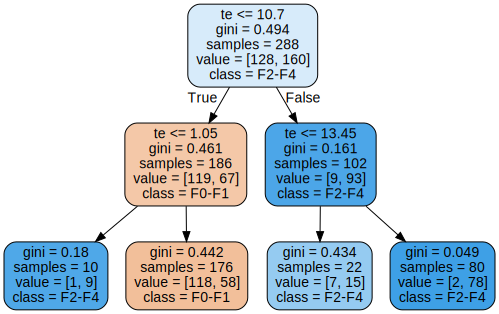

In [81]:
try:
    from graphviz import Source
    from sklearn.tree import export_graphviz

    tree = cross_validate(clf_tree, X=_X, y=_y, cv=5,  scoring=scoring, return_estimator=True)

    fname_tree_dot = os.path.join('figures', "decision_tree.dot")

    export_graphviz(
            tree['estimator'][0],
            out_file=fname_tree_dot,
            feature_names=['te'],
            class_names=['F0-F1', 'F2-F4'],
            rounded=True,
            filled=True
        )
    display(Source.from_file(fname_tree_dot))
except ModuleNotFoundError as e:
    print("Error:", e)
    pass
except Exception as e:
    print("Error:", e)
    pass

In [82]:
tree['estimator'][0].random_state

42

#### Rebuild `run_cv_binary` to get roc_curve value

In [83]:
from collections import defaultdict

from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

CV_FOLDS = 5
CV_REPEATS = 10

def run_cv_binary(clf_dict:dict, X:pd.DataFrame, y:pd.Series, cv=CV_FOLDS, n_repeats=CV_REPEATS,
                  scoring=scorer_dict,
                  prefix='')-> dict:
    """Run Cross Validation (cv) for binary classification example
    for a set of classifiers.
    
    
    Inputs
    ------
    clf_dict: dict
        Dictionary with keys and scikit-learn classifiers as values.
    X: 2D-array, pd.DataFrame
        Input data
    y: 1D-array, pd.Series
        Targets for classification
    cv: int
        Number of splits for Cross-Validation.
    prefix: str
        Prefix for clf-key for custom naming.
    
    Returns
    -------
    dict: dict with keys of clf_dict and computed results for each run. 
    """
    cv_results = {}
    roc_curve_results = defaultdict(list)
   
    rskf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=n_repeats, random_state=0) 
    
    for key_clf, clf in clf_dict.items():
        key_clf = prefix + key_clf
        
        _cv_results = defaultdict(list)
        
        for i, (train_index, test_index) in enumerate(rskf.split(X,y)):
            X_train = X.iloc[train_index]
            X_test = X.iloc[test_index]
            y_train = y.iloc[train_index]
            y_test = y.iloc[test_index]

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_score = clf.predict_proba(X_test)
            
            for metric_name, metric_fct in scorer_dict.items():
                if metric_name == 'roc_auc':
                    _cv_results[metric_name].append(metric_fct(y_test, y_score[:,1]))
                else:
                    _cv_results[metric_name].append(metric_fct(y_test, y_pred))

            _cv_results['num_feat'].append(X.shape[-1])
            _cv_results['n_obs'].append(len(y))

            
            fpr, tpr, cutoffs = roc_curve(y_test, y_score[:, 1])
            roc_curve_results[key_clf].append((fpr, tpr, cutoffs))
            _cv_results['roc_auc_2'].append(auc(fpr, tpr))

        cv_results[key_clf] = dict(_cv_results)
        
    return cv_results, dict(roc_curve_results)
results_dict, roc_curve_results = run_cv_binary(clf, X=_X, y=_y, prefix='F2_')

Display CV results (metrics):

In [84]:
_get_cv_means(results_dict)

variable    precision           recall                  f1            \
statistics       mean       std   mean       std      mean       std   
F2_Logistic  0.828666  0.064967  0.715  0.072457  0.764171  0.048121   
F2_f2_te     0.762988  0.047561  0.765  0.063836  0.762498  0.045087   

variable    balanced_accuracy             roc_auc           num_feat       \
statistics               mean       std      mean       std     mean  std   
F2_Logistic           0.76125  0.048251  0.816625  0.050649      1.0  0.0   
F2_f2_te              0.73250  0.048101  0.732500  0.048101      1.0  0.0   

variable     n_obs      roc_auc_2            
statistics    mean  std      mean       std  
F2_Logistic  360.0  0.0  0.816625  0.050649  
F2_f2_te     360.0  0.0  0.732500  0.048101

Plot ROC curves of these CV runs

Using Stratified Splitting is default for [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate).

In [85]:
from sklearn.model_selection import StratifiedKFold

cv_results = {}
for key, _clf in clf_sklearn.items(): 
    cv_results[key] = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)

In [86]:
_get_cv_means(cv_results)

variable   fit_time           score_time           test_balanced_accuracy  \
statistics     mean       std       mean       std                   mean   
Logistic    0.00295  0.000734   0.006689  0.001058                0.76125   

variable               test_f1           test_precision           test_recall  \
statistics       std      mean       std           mean       std        mean   
Logistic    0.048251  0.764171  0.048121       0.828666  0.064967       0.715   

variable             test_roc_auc            
statistics       std         mean       std  
Logistic    0.072457     0.816625  0.050649

#### Learn imputation on fold?
Include Preprocessing (here: imputation into the pipeline). 

> write custom [`FunctionTransformer`](https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers) to included preprocessing.


In [87]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

def custom_preprocessing_function(X):
    """Operate on a a set of rows from the dataset.
    here: apply imputation to log-transformed values?
    """
    raise NotImplementedError

# clf = make_pipeline( FunctionTransformer(custom_preprocessing_function), svm.SVC(C=1))
# cross_val_score(clf, X, y, cv=cv)

#### Comment: 
- Yes recursive feature selection would be good. I tried forward feature selection before to see where score matrix (e.g test-auc) reaches a plateau. In the end I decided a strategy to first select best 10 features based on auc, then perform a greedy search against all n-feature combos among the 10, then select the best feature combo based on MCC score. Afterwards I validate on the validation dataset which I stratified-split at the beginning.

To add
-  [x] Stratification of input data
-  [ ] Recursive feature selection
-  [ ] cutoff determination for binary classification (ROC-Curves, Precision-Recall-Curves)
    - needs a validation split

[Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) based on mutual information

## Individual Models for three endpoints fibrosis, steatosis and inflammation
Strategy for feature selection and model performance validation: 3 models to be built, fibrosis (F0-1 vs. F2-4, and F0-2 vs. F3-4), inflammation (0-1 vs. 2-5) and steatosis (0 vs. >0). Then compare each model with their respective existing best-in-class markers according to their standard cut-offs in clinic. 

### Top k selected proteins for prediction
[Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) based on mutual information. 

Each endpoint will yield different `top-k` proteins. An aggregation strategy in the simplest form is to combine the top-k. Maybe there is also some kind of rank-algorithm combining the top-k minimizing the overall rank?

In [88]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

class FeatureSelector():
    """Namespace for feature selection.
    Uses mutal information to select k best features. 
    Can combine the best for a set of targets to a combined maximum.
    
    Parameters
    ----------
    k: int
        top-k features for each endpoint
    protein_gene_data: pandas.DataFrame (shape: X_N, 1)
        Optional mapping of index of DataFrame passed to fit method
        to values in protein_gene_data. Here this is the associated gene-name
        to a protein.
    
    """
    
    def __init__(self, k=10, protein_gene_data=None):
        self.k = k
        self.protein_gene_id = protein_gene_data
        if protein_gene_data is not None:
            self.endpoints_features_ = pd.DataFrame()
        else:
            self.endpoints_features_ = None
        
    def fit(self, X: pd.DataFrame, y: pd.Series, col_name='target'):
        mask_samples_in_both = X.index.intersection(y.index)
        k_best = SelectKBest(mutual_info_classif, k=self.k)
        k_best.fit(X.loc[mask_samples_in_both], y=y.loc[mask_samples_in_both])
        
        selected_ = k_best.get_support()
        selected_ = X.columns[selected_]
        result = key_ProteinID.loc[selected_]
        result = result.fillna('NoGene')
        result.columns = [col_name]
        if self.endpoints_features_ is not None:
            self.endpoints_features_ = self.endpoints_features_.join(result, how='outer')
        else:
            print("Not able to aggregate as no protein_gene_data was passed.")
        return result
    

feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')

In [89]:
feature_selected.endpoints_features_

,F2,F3,S1,I2
Protein ID,,,,
A0A0G2JMB2,IGHA2,NaN,NaN,NaN
A0A286YEY1,NaN,IGHA1,NaN,IGHA1
C9JPQ9,NaN,NaN,FGG,NaN
H7BY64,NaN,NaN,NoGene,NaN
O00391,QSOX1,QSOX1,NaN,QSOX1
P00739,HPR,NaN,NaN,NaN
P01833,PIGR,NaN,NaN,PIGR
P02743,APCS,APCS,NaN,NaN
P05062,NaN,NaN,ALDOB,NaN


In [90]:
feature_selected.endpoints_features_.notna().sum(axis=1)

Protein ID
A0A0G2JMB2    1
A0A286YEY1    2
C9JPQ9        1
H7BY64        1
O00391        3
P00739        1
P01833        2
P02743        2
P05062        1
P05362        1
P05546        1
P06396        1
P08519        1
P10643        3
P10909        1
P19320        3
P23142        1
P27169        1
P35858        1
P51884        1
P55103        1
Q08380        4
Q15582        1
Q16270        3
Q92820        1
Q9Y5Y7        1
dtype: int64

Selection could also be based on number of shared proteins being among the top 10. The degree of importance can be investigate. If the top10 for each endpoint are similar important selection based on the number of shared top-k between endpoints could be sensible.

In [91]:
proteins_selected = feature_selected.endpoints_features_.index[:10]
list(proteins_selected)

['A0A0G2JMB2',
 'A0A286YEY1',
 'C9JPQ9',
 'H7BY64',
 'O00391',
 'P00739',
 'P01833',
 'P02743',
 'P05062',
 'P05362']

### Executor 

corresponds to main function in a script. Allows changes over all endpoints simultaneously. 

In [92]:
class MainExecutorCV():
    """Class to call cross-validation."""
    
    def __init__(self, proteomics_data, clinical_data, cutoffs_clinic, clf_sklearn, endpoints_defined=['F2', 'F3', 'S1', 'I2']):
        self.data_proteomics = proteomics_data
        self.data_clinic = clinical_data
        self.cutoffs_clinic = cutoffs_clinic
        self.endpoints_defined = endpoints_defined
        self.clf_sklearn = clf_sklearn
    
    @staticmethod
    def cutoff_classifier(cutoffs:dict)-> dict:
        """Takes a dictionary of key:cutoff values and returns
        univariate ThresholdClassifiers for each key-cutoff-pair."""
        clf_threshold = {}
        for key, value in cutoffs.items():
            clf_threshold[key] = ThresholdClassifier(threshold={key:value})
        return clf_threshold

    def run_evaluation(self, y:pd.Series, endpoint:str, additional_markers:list, proteins_selected:pd.Index, verbose=False):
        """Custom function to run standarda analysis for an endpoint based on 
        predefined cutoffs, specified clinical variables"""
        assert endpoint in self.endpoints_defined

        cutoffs_endpoint = cutoffs_clinic[endpoint].dropna().to_dict()
        clf_endpoint_threshold = self.cutoff_classifier(cutoffs_endpoint)
        if verbose: display(clf_endpoint_threshold)
        
        X = self.data_clinic.loc[y.index, cutoffs_clinic[endpoint].keys()]
        if verbose: display(X.describe())
            
        results = {}
        auc_scores = {}
        
        for key, clf in clf_endpoint_threshold.items():
            _X = X[key].to_frame().dropna()
            _y = y.loc[_X.index].dropna()
            assert _X.isna().sum().sum() == 0
            assert _y.isna().sum() == 0

            _res, _auc_roc = run_cv_binary({f'{endpoint}_marker_{key}':clf}, X=_X, y=_y)
            results.update(_res)
            auc_scores.update(_auc_roc)
            
        for key in additional_markers:
            _X = X[key].to_frame().dropna()
            _y = y.loc[_X.index].dropna()
            assert _X.isna().sum().sum() == 0
            assert _y.isna().sum() == 0
    
            for key_clf, clf in self.clf_sklearn.items():
                _res, _auc_roc = run_cv_binary({f'{endpoint}_marker_{key}_{key_clf}':clf}, X=_X, y=_y)
                results.update(_res)
                auc_scores.update(_auc_roc)
        
        _X = self.data_proteomics[proteins_selected.index]
        in_both = y.index.intersection(_X.index)
        _X = _X.loc[in_both]
        _y = y.loc[in_both]
        
        _res, _auc_roc = run_cv_binary(self.clf_sklearn, X=_X, y=_y, prefix=f'{endpoint}_prot_')
        results.update(_res)
        auc_scores.update(_auc_roc)

        return results, auc_scores

cv_executor = MainExecutorCV(proteomics_data=data_proteomics, clinical_data=data_cli, clf_sklearn=clf_sklearn, cutoffs_clinic=cutoffs_clinic)

1. Models based on clinical marker thresholds (Clinical Reference Models)
2. Additional Models based on clinical markers (having no standard cutoffs defined)
3. Proteomics Models based on protein intensities

Performance depends on the number of available features (varies!) 

### Fibrosis

#### F2

In [93]:
kleiner_ge_2.value_counts(dropna=False)

1    200
0    160
Name: kleiner, dtype: int64

In [94]:
cutoffs_f2 = cutoffs_clinic['F2'].dropna().to_dict()
cutoffs_f2

{'te': 7.0, 'swe': 8.6, 'elf': 7.7, 'ft': 0.48, 'fib4': 1.45, 'apri': 0.5}

In [95]:
y = kleiner_ge_2.astype(int)
y.describe()

count    360.000000
mean       0.555556
std        0.497596
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: kleiner, dtype: float64

In [96]:
f2_results, f2_auc_scores = cv_executor.run_evaluation(y=kleiner_ge_2,
                                                       endpoint='F2',
                                                       additional_markers=['forns', 'p3np'],
                                                       proteins_selected=proteins_selected_f2,
                                                       verbose=True)

{'te': ThresholdClassifier(cutoff=0.5, threshold={'te': 7.0}),
 'swe': ThresholdClassifier(cutoff=0.5, threshold={'swe': 8.6}),
 'elf': ThresholdClassifier(cutoff=0.5, threshold={'elf': 7.7}),
 'ft': ThresholdClassifier(cutoff=0.5, threshold={'ft': 0.48}),
 'fib4': ThresholdClassifier(cutoff=0.5, threshold={'fib4': 1.45}),
 'apri': ThresholdClassifier(cutoff=0.5, threshold={'apri': 0.5})}

marker,te,swe,elf,ft,fib4,apri,forns,p3np,m30,m65,aar,cap
count,341.000000,331.000000,349.000000,268.000000,352.000000,353.000000,356.000000,319.000000,268.000000,266.000000,352.000000,205.000000
mean,16.260704,13.842900,9.777650,0.347351,2.534773,0.703683,5.630197,13.279937,233.677756,685.670989,1.367727,287.107317
std,18.386198,11.711420,1.510562,0.286632,3.027889,0.992125,2.394013,12.439905,297.008804,850.377366,0.764461,63.930402
min,2.100000,2.100000,6.900000,0.020000,0.270000,0.080000,-1.540000,1.500000,2.126260,82.780701,0.090000,100.000000
25%,5.600000,6.500000,8.700000,0.100000,0.950000,0.240000,4.012500,6.750000,95.456402,271.321750,0.877500,245.000000
50%,8.700000,8.700000,9.400000,0.245000,1.570000,0.400000,5.515000,9.000000,153.139500,440.100005,1.130000,286.000000
75%,18.200001,15.850000,10.700000,0.542500,2.892500,0.770000,7.142500,14.450000,261.165740,835.044495,1.640000,331.000000
max,75.000000,75.599998,14.800000,0.980000,32.700001,11.630000,12.580000,112.500000,3816.990000,10015.900000,4.710000,400.000000


In [97]:
result_table_f2 = _get_cv_means(f2_results).sort_values(('f1', 'mean'), ascending = False)
result_table_f2

variable                 precision              recall                  f1  \
statistics                    mean       std      mean       std      mean   
F2_prot_Logistic          0.832388  0.040610  0.788949  0.064134  0.808201   
F2_marker_te              0.762716  0.043139  0.822674  0.062283  0.790254   
F2_marker_swe             0.797098  0.047761  0.777778  0.050918  0.786365   
F2_marker_forns_Logistic  0.726811  0.041751  0.771782  0.068239  0.746539   
F2_marker_fib4            0.746835  0.047333  0.745000  0.063830  0.744388   
F2_marker_p3np_Logistic   0.828358  0.064132  0.671277  0.081386  0.737268   
F2_marker_elf             0.572836  0.010215  0.994858  0.010284  0.726969   
F2_marker_apri            0.835903  0.047946  0.566397  0.066851  0.672967   
F2_marker_ft              0.908408  0.060878  0.493177  0.093327  0.635021   

variable                           balanced_accuracy             roc_auc  \
statistics                     std              mean       std      mean   
F2_prot_Logistic          0.038613          0.793597  0.036875  0.884170   
F2_marker_te              0.041775          0.756498  0.046094  0.756498   
F2_marker_swe             0.041280          0.769695  0.044515  0.769695   
F2_marker_forns_Logistic  0.039279          0.704077  0.042082  0.810735   
F2_marker_fib4            0.044674          0.712198  0.049367  0.712198   
F2_marker_p3np_Logistic   0.052634          0.751777  0.044477  0.804933   
F2_marker_elf             0.008601          0.532913  0.017608  0.532913   
F2_marker_apri            0.054406          0.713098  0.038688  0.713098   
F2_marker_ft              0.085955          0.718819  0.053897  0.718819   

variable                           num_feat       n_obs      roc_auc_2  \
statistics                     std     mean  std   mean  std      mean   
F2_prot_Logistic          0.030547     10.0  0.0  358.0  0.0  0.884170   
F2_marker_te              0.046094      1.0  0.0  341.0  0.0  0.756498   
F2_marker_swe             0.044515      1.0  0.0  331.0  0.0  0.769695   
F2_marker_forns_Logistic  0.038169      1.0  0.0  356.0  0.0  0.810735   
F2_marker_fib4            0.049367      1.0  0.0  352.0  0.0  0.712198   
F2_marker_p3np_Logistic   0.051008      1.0  0.0  319.0  0.0  0.804933   
F2_marker_elf             0.017608      1.0  0.0  349.0  0.0  0.532913   
F2_marker_apri            0.038688      1.0  0.0  353.0  0.0  0.713098   
F2_marker_ft              0.053897      1.0  0.0  268.0  0.0  0.718819   

variable                            
statistics                     std  
F2_prot_Logistic          0.030547  
F2_marker_te              0.046094  
F2_marker_swe             0.044515  
F2_marker_forns_Logistic  0.038169  
F2_marker_fib4            0.049367  
F2_marker_p3np_Logistic   0.051008  
F2_marker_elf             0.017608  
F2_marker_apri            0.038688  
F2_marker_ft              0.053897

#### F3

In [98]:
kleiner_ge_3.value_counts(dropna=False)

0    266
1     94
Name: kleiner, dtype: int64

In [99]:
cutoffs_f3 = cutoffs_clinic['F3'].dropna().to_dict()
cutoffs_f3

{'te': 15.0,
 'swe': 16.4,
 'elf': 10.5,
 'ft': 0.58,
 'fib4': 3.25,
 'apri': 1.0,
 'forns': 6.8}

Two clinical markers have no cutoff defined in the literature. Therefore we have to learn these

In [100]:
f3_results, f3_auc_scores = cv_executor.run_evaluation(y=kleiner_ge_3, endpoint='F3', 
                                                       additional_markers=['p3np'], 
                                                       proteins_selected=proteins_selected_f3)
result_table_f3 = _get_cv_means(f3_results).sort_values(('f1', 'mean'), ascending = False)
result_table_f3

variable                precision              recall                  f1  \
statistics                   mean       std      mean       std      mean   
F3_marker_te             0.797566  0.073238  0.894118  0.066551  0.840594   
F3_marker_swe            0.856742  0.070448  0.831103  0.089408  0.840261   
F3_prot_Logistic         0.818404  0.077626  0.714971  0.087698  0.760191   
F3_marker_elf            0.705481  0.066317  0.755556  0.085346  0.726493   
F3_marker_forns          0.645443  0.073630  0.702398  0.086738  0.669815   
F3_marker_ft             0.654438  0.108230  0.636593  0.126335  0.638719   
F3_marker_fib4           0.692626  0.084706  0.576023  0.102020  0.624457   
F3_marker_p3np_Logistic  0.767904  0.142637  0.428750  0.125577  0.539188   
F3_marker_apri           0.519704  0.113700  0.370117  0.101418  0.426921   

variable                          balanced_accuracy             roc_auc  \
statistics                    std              mean       std      mean   
F3_marker_te             0.055138          0.908013  0.037463  0.908013   
F3_marker_swe            0.062089          0.891339  0.046145  0.891339   
F3_prot_Logistic         0.070092          0.828995  0.047321  0.944867   
F3_marker_elf            0.059014          0.821748  0.042949  0.821748   
F3_marker_forns          0.066631          0.780553  0.049100  0.780553   
F3_marker_ft             0.097037          0.761376  0.066801  0.761376   
F3_marker_fib4           0.080900          0.741858  0.052261  0.741858   
F3_marker_p3np_Logistic  0.115022          0.692317  0.063536  0.842250   
F3_marker_apri           0.097730          0.623759  0.053638  0.623759   

variable                          num_feat       n_obs      roc_auc_2  \
statistics                    std     mean  std   mean  std      mean   
F3_marker_te             0.037463      1.0  0.0  341.0  0.0  0.908013   
F3_marker_swe            0.046145      1.0  0.0  331.0  0.0  0.891339   
F3_prot_Logistic         0.024571     10.0  0.0  358.0  0.0  0.944867   
F3_marker_elf            0.042949      1.0  0.0  349.0  0.0  0.821748   
F3_marker_forns          0.049100      1.0  0.0  356.0  0.0  0.780553   
F3_marker_ft             0.066801      1.0  0.0  268.0  0.0  0.761376   
F3_marker_fib4           0.052261      1.0  0.0  352.0  0.0  0.741858   
F3_marker_p3np_Logistic  0.047341      1.0  0.0  319.0  0.0  0.842250   
F3_marker_apri           0.053638      1.0  0.0  353.0  0.0  0.623759   

variable                           
statistics                    std  
F3_marker_te             0.037463  
F3_marker_swe            0.046145  
F3_prot_Logistic         0.024571  
F3_marker_elf            0.042949  
F3_marker_forns          0.049100  
F3_marker_ft             0.066801  
F3_marker_fib4           0.052261  
F3_marker_p3np_Logistic  0.047341  
F3_marker_apri           0.053638

If the models are trained on the fibrosis data only, on could expect some predictions of fibrosis patients in the untested healthy patient (hp) cohort.

#### Comment: Healthy patients - Select for testing
- Yes, that is a good idea. One can also predict on the test set and ask for a re-examination of the patient (or re-evaluation of the histology score), or to look into the outcome data which we might get access to soon. We might expect some "false prediction" to be "under-diagnosed" cases and vice versa.

#### Healthy vs Fibrosis patients

How many healthy patients would be predicted to have fibrosis?

#### Comment:
- I agree. Ideally we would need an independent cohort for validation but is not possible in this case. So we can split a validation cohort from the beginning, and leave it out of the entire machine learning process - feature selection, model building, parameter fine-tuning. The problem is with random split, there is still a factor of randomness...I doubt if it will be a good reflection of the model performance. Not sure if there is a better solution. Maybe we can split based on the year of sample collection. Something to have in mind. 

### Inflamation

In [101]:
inflamation_ge_2.value_counts(dropna=False)

1    189
0    163
Name: nas_inflam, dtype: int64

In [102]:
cutoffs_i2 = cutoffs_clinic['I2'].dropna().to_dict()
cutoffs_i2

{'aar': 2.0}

##### Reference Model: Based on clinical markerthresholds

In [103]:
i2_results, i2_auc_scores = cv_executor.run_evaluation(y=inflamation_ge_2, endpoint='I2', 
                                                       additional_markers=['m30', 'm65'], 
                                                       proteins_selected=proteins_selected_I2)
result_table_i2 = _get_cv_means(i2_results).sort_values(('f1', 'mean'), ascending = False)
result_table_i2

variable               precision              recall                  f1  \
statistics                  mean       std      mean       std      mean   
I2_prot_Logistic        0.780870  0.055914  0.764410  0.063825  0.770306   
I2_marker_m30_Logistic  0.757184  0.083973  0.590159  0.093366  0.659028   
I2_marker_m65_Logistic  0.725609  0.071553  0.560423  0.084624  0.629472   
I2_marker_aar           0.820018  0.089742  0.210811  0.048044  0.332261   

variable                         balanced_accuracy             roc_auc  \
statistics                   std              mean       std      mean   
I2_prot_Logistic        0.043687          0.755103  0.046629  0.827576   
I2_marker_m30_Logistic  0.075101          0.690326  0.061505  0.768228   
I2_marker_m65_Logistic  0.069642          0.666689  0.056124  0.714034   
I2_marker_aar           0.060875          0.577139  0.025278  0.577139   

variable                         num_feat       n_obs      roc_auc_2            
statistics                   std     mean  std   mean  std      mean       std  
I2_prot_Logistic        0.039381     10.0  0.0  350.0  0.0  0.827576  0.039381  
I2_marker_m30_Logistic  0.064097      1.0  0.0  266.0  0.0  0.768228  0.064097  
I2_marker_m65_Logistic  0.048740      1.0  0.0  264.0  0.0  0.714034  0.048740  
I2_marker_aar           0.025278      1.0  0.0  344.0  0.0  0.577139  0.025278

Data will have to depend on the number of available features in the 

Two clinical markers have no cutoff defined in the literature. Therefore we have to learn these

### Steatosis

In [104]:
steatosis_ge_1.value_counts(dropna=False)

1    196
0    156
Name: nas_steatosis_ordinal, dtype: int64

In [105]:
cutoffs_s1 = cutoffs_clinic['S1'].dropna().to_dict()
cutoffs_s1

{'cap': 290.0}

Data will have to depend on the number of available features in the 

In [106]:
y = steatosis_ge_1.astype(int)
y.describe()

count    352.000000
mean       0.556818
std        0.497468
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nas_steatosis_ordinal, dtype: float64

In [107]:
s1_results, s1_auc_scores = cv_executor.run_evaluation(y=steatosis_ge_1, endpoint='S1', 
                                                       additional_markers=[], 
                                                       proteins_selected=proteins_selected_s1)
result_table_s1 = _get_cv_means(s1_results).sort_values(('f1', 'mean'), ascending = False)
result_table_s1

variable         precision              recall                  f1            \
statistics            mean       std      mean       std      mean       std   
S1_prot_Logistic  0.794839  0.042760  0.841244  0.043774  0.816307  0.031585   
S1_marker_cap     0.891058  0.059481  0.632738  0.087765  0.736820  0.070223   

variable         balanced_accuracy             roc_auc           num_feat  \
statistics                    mean       std      mean       std     mean   
S1_prot_Logistic          0.780740  0.039631  0.851838  0.033041     10.0   
S1_marker_cap             0.745941  0.062205  0.745941  0.062205      1.0   

variable               n_obs      roc_auc_2            
statistics        std   mean  std      mean       std  
S1_prot_Logistic  0.0  350.0  0.0  0.851838  0.033041  
S1_marker_cap     0.0  199.0  0.0  0.745941  0.062205

### Write results to Excel

In [108]:
FILE_RESULTS = 'results.xlsx'

with pd.ExcelWriter(FILE_RESULTS) as writer:
    result_table_f2.to_excel(writer, sheet_name='F2')
    result_table_f3.to_excel(writer, sheet_name='F3')
    result_table_i2.to_excel(writer, sheet_name='I2')
    result_table_s1.to_excel(writer, sheet_name='S1')

### Plot Results of three endpoints (F2, I2, S1)

- create [enumeration of subplots](https://stackoverflow.com/a/25544329/9684872) starting at a)

#### Performance Plots based on results DataFrame for a endpoint

In [109]:
display(result_table_s1)
result_table = result_table_s1
names = list(result_table.index)

def _process_names(index):
    names = list(index)
    names = [x.split('_') for x in names]
    endpoint = names[0][0]
    
    def _process_index_names(_l:list):
        if 'marker' in _l:
            _l.remove('marker')
        return _l
    
    for _l in names: assert endpoint == _l[0] , f"Mixed endpoints: {endpoint} and {_l[0]}"
    names = [" ".join(_process_index_names(_l[1:])).lower() for _l in names]
    return names
   
_process_names(result_table.index)

variable         precision              recall                  f1            \
statistics            mean       std      mean       std      mean       std   
S1_prot_Logistic  0.794839  0.042760  0.841244  0.043774  0.816307  0.031585   
S1_marker_cap     0.891058  0.059481  0.632738  0.087765  0.736820  0.070223   

variable         balanced_accuracy             roc_auc           num_feat  \
statistics                    mean       std      mean       std     mean   
S1_prot_Logistic          0.780740  0.039631  0.851838  0.033041     10.0   
S1_marker_cap             0.745941  0.062205  0.745941  0.062205      1.0   

variable               n_obs      roc_auc_2            
statistics        std   mean  std      mean       std  
S1_prot_Logistic  0.0  350.0  0.0  0.851838  0.033041  
S1_marker_cap     0.0  199.0  0.0  0.745941  0.062205

['prot logistic', 'cap']

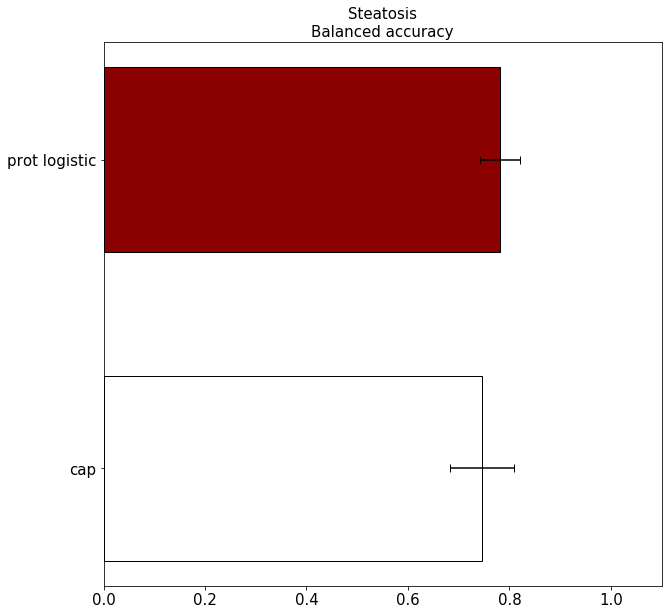

In [110]:
def plot_performance(ax, result, metric, title):
    '''result as result table from _get_cv_means(results)'''
    df = result.copy()
    df = df.sort_values(by = [(metric, 'mean')])
    colors = np.where(['prot' in row for row in df.index], 'darkred', 'white')
    df.index = _process_names(df.index)
    # fig, ax = plt.subplots(figsize=(3, 4))
    y = df.index
    width = df[(metric, 'mean')]
    xerr = df[(metric, 'std')]
    ax.set_xlim(0, 1.1)
    ax.tick_params(labelsize = 15)
    ax.barh(y=y, width=width, xerr=xerr, capsize=4, color=colors, height=0.6, edgecolor='black')
    
    metric_name = " ".join(metric.split('_')).capitalize()
    if metric == 'f1': metric_name += ' score'
    ax.set_title('{}\n{}'.format(title, metric_name), fontsize=15)

  
#  (result_table_s1, s1_auc_scores, 'NAS Steatosis >= 5%', 'S1_prot_Logistic')
    
fig, ax = plt.subplots(figsize=(10,10))
plot_performance(ax, result_table_s1, 'balanced_accuracy', 'Steatosis')

#### AUC-ROC Curves based on CV result for an endpoint

95% CI:(0.8061407070887436, 0.8338592929112563)


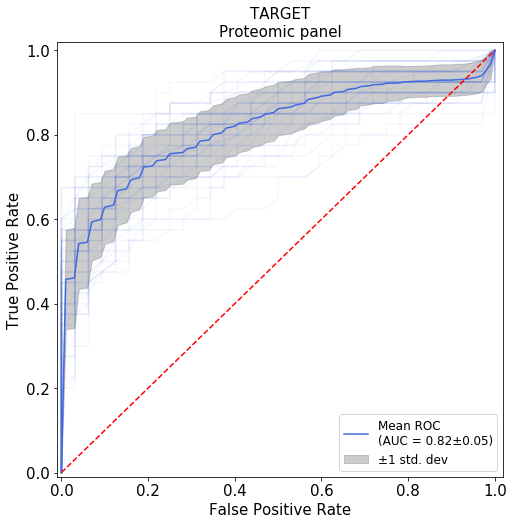

In [111]:
def plot_roc_curve(ax, runs_roc_auc_scores, endpoint=''):
        tprs = []
        base_fpr = np.linspace(0, 1, 101)
        roc_aucs = []
        for fpr, tpr, threshold in runs_roc_auc_scores:
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            
            ax.plot(fpr, tpr, 'royalblue', alpha=0.05)
            
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0]=0.0
            tprs.append(tpr)
    
        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        tprs_upper = mean_tprs + std
        tprs_lower = mean_tprs - std

        mean_rocauc = np.mean(roc_aucs).round(2)
        sd_rocauc = np.std(roc_aucs).round(2)
        se_rocauc = sd_rocauc/np.sqrt(len(roc_aucs))

        CI = (mean_rocauc-1.96 * se_rocauc, mean_rocauc + 1.96 * se_rocauc)

        ax.plot(base_fpr, mean_tprs, color = 'royalblue', 
                 label = 'Mean ROC\n(AUC = {}±{})'.format(mean_rocauc, sd_rocauc))
        ax.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.4, label = '±1 std. dev')

        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([-0.01, 1.02])
        ax.set_ylim([-0.01, 1.02])
        ax.set_ylabel('True Positive Rate', fontsize = 15)
        ax.set_xlabel('False Positive Rate', fontsize = 15)
        ax.tick_params(labelsize = 15)
        ax.legend(fontsize = 12)
        ax.set_title('{}\nProteomic panel'.format(endpoint), fontsize = 15)
        #  plt.savefig('figures/ROC_{}.pdf'.format(endpoint), dpi=120, bbox_inches='tight')
        print("95% CI:{}".format(CI))

fig, ax = plt.subplots(figsize=(8, 8))      
        
plot_roc_curve(ax, roc_curve_results['F2_Logistic'], 'TARGET')

#### Build final figure for publication

95% CI:(0.8716844242532462, 0.8883155757467538)
95% CI:(0.8189125656709949, 0.841087434329005)
95% CI:(0.8416844242532462, 0.8583155757467538)


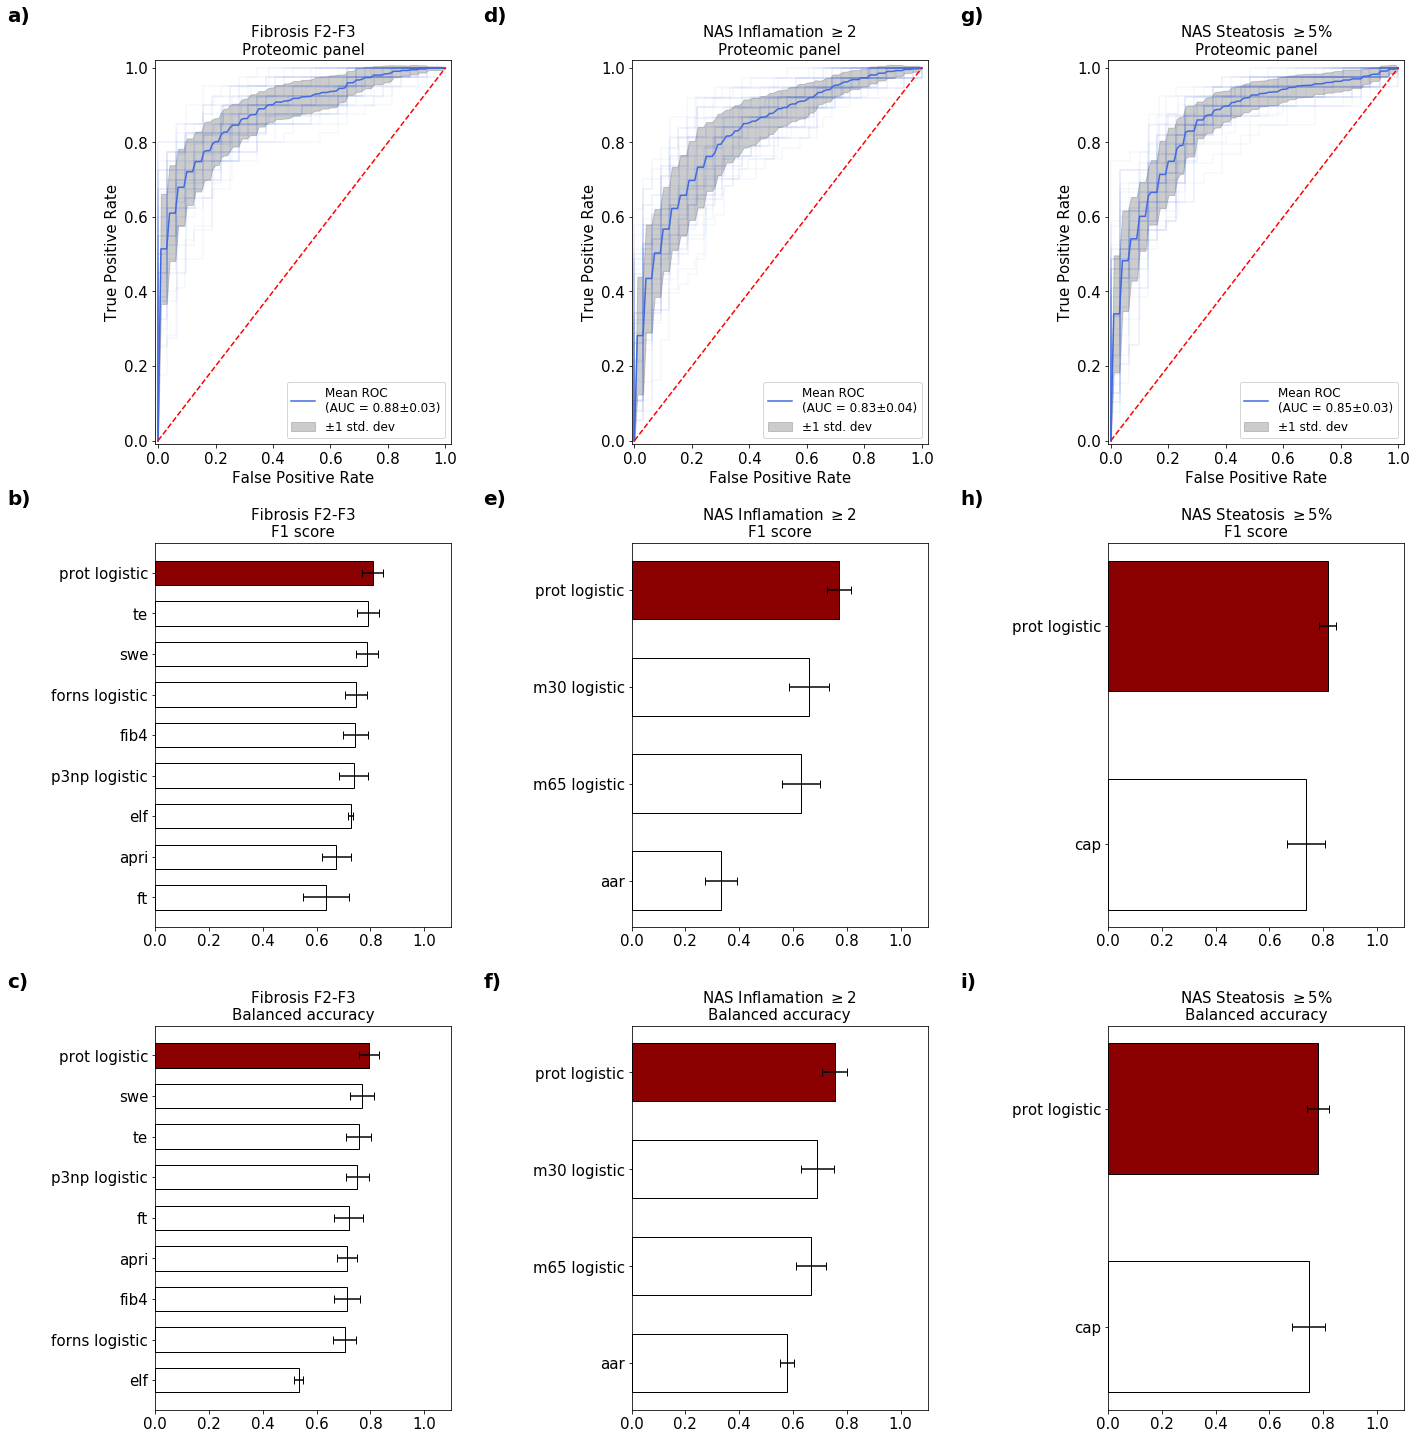

In [112]:
import string
fig, axs = plt.subplots(3,3,figsize=(20,20))

n=0
result_tuples = [
 (result_table_f2, f2_auc_scores, 'Fibrosis F2-F3', 'F2_prot_Logistic'), 
 (result_table_i2, i2_auc_scores, 'NAS Inflamation $\geq 2$', 'I2_prot_Logistic'), 
 (result_table_s1, s1_auc_scores, 'NAS Steatosis $\geq 5$%', 'S1_prot_Logistic')
]

for col, (result_table, result_auc_scores, endpoint_title, auc_model_name) in enumerate(result_tuples):
    
    ax = axs[0,col]
    plot_roc_curve(ax, result_auc_scores[auc_model_name], endpoint_title)
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    n+=1
    
    ax = axs[1,col]
    plot_performance(ax, result=result_table, metric='f1', title=endpoint_title)   
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    n+=1
    
    ax = axs[2,col]
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    plot_performance(ax, result=result_table, metric='balanced_accuracy', title=endpoint_title)   

    n+=1

fig.tight_layout()
fig.savefig('figures/Figure_6.pdf', dpi=120, pad_inches=0.1, bbox_inches='tight')

## Multiclass, Multivariate Models
- predict single classes for each endpoint in a joint model.
- 

### Multiclass Fibrosis
- Predict 4 categories for fibrosis

In [113]:
kleiner_score = Y.kleiner.dropna()
y = kleiner_score

In [114]:
indices = data_proteomics.index.intersection(y.index)
X_train = data_proteomics.loc[indices]
y = y.loc[indices].astype(int)

In [115]:
clf_rf.fit(X_train, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=29, verbose=0,
                       warm_start=False)

In [116]:
clf_rf.classes_

array([0, 1, 2, 3, 4])

In [117]:
y_train_pred = sklms.cross_val_predict(clf_rf, X_train, y, cv=5)

In [118]:
conf_mx = sklm.confusion_matrix(y, y_train_pred)
conf_mx

array([[ 0, 34,  1,  0,  0],
       [ 0, 97, 26,  0,  1],
       [ 0, 45, 51,  0, 10],
       [ 0,  3, 12,  0, 12],
       [ 0,  0, 18,  0, 48]], dtype=int64)

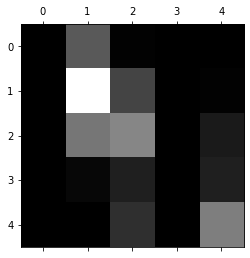

In [119]:
plt.matshow(conf_mx, cmap=plt.cm.gray) 
plt.show()

In [120]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
display(row_sums)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[ 35],
       [124],
       [106],
       [ 27],
       [ 66]], dtype=int64)

array([[0.        , 0.97142857, 0.02857143, 0.        , 0.        ],
       [0.        , 0.78225806, 0.20967742, 0.        , 0.00806452],
       [0.        , 0.4245283 , 0.48113208, 0.        , 0.09433962],
       [0.        , 0.11111111, 0.44444444, 0.        , 0.44444444],
       [0.        , 0.        , 0.27272727, 0.        , 0.72727273]])

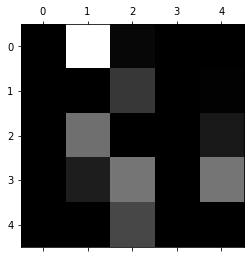

In [121]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [122]:
sklm.accuracy_score(y, y_train_pred)

0.547486033519553

### Multiclass model inflammation

### Multiclass model steatosis

### Joint prediction of the three multiclass targets

## Versions

In [123]:
pip list | grep pandas

pandas             1.0.3              
Note: you may need to restart the kernel to use updated packages.


In [124]:
pip list | grep scikit

scikit-learn       0.22.1             Note: you may need to restart the kernel to use updated packages.

